In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import re
import h5py

from functools import reduce
from itertools import combinations
from ttt.utils import listfiles
from mlr.database.utils import read_metadata, write_metadata
from matplotlib import cm

import ipywidgets as widgets
from ipywidgets import (IntSlider, RadioButtons, SelectMultiple, Layout, Checkbox, fixed, interact, FloatRangeSlider, Button)
from matplotlib.lines import Line2D

In [2]:
def read_training_history(path):
    history_file = h5py.File(path,'r')
    history_dict = {x:np.array(y) for x, y in history_file.items()} 
    history_file.close()
    return history_dict

In [3]:
root_dir_base = pathlib.Path("/media/files/segmentation_networks/")
root_dirs = [root_dir_base.joinpath("substrate_networks_with_callbacks_2_8_2022"),
            root_dir_base.joinpath("transfer_learning_2_15_2022")
            ]

root_dirs = [folder.joinpath("trained_models") for folder in root_dirs]
model_folders = [[x for x in listfiles(r) if x.is_dir()] for r in root_dirs]
model_folders = reduce(lambda x,y: x+y, model_folders)

In [4]:
## load all the metadata from the networks
metadata_list = []
for folder in model_folders:
    try:
        model_metadata = read_metadata(folder.joinpath("metadata.json"))    
    except:
        continue
    model_id = re.search("[0-9]+_[0-9]+", str(folder).rsplit("/")[-1])[0]
    model_metadata["ID"] = model_id

    
    if "transfer" in str(folder):    
        tl = True
        history_path = "sm_unet_transferLearnWeights_" + model_metadata["backbone"]+"_history.h5"
        history_dict = read_training_history(folder.joinpath(history_path))
        model_metadata.update(history_dict)
        model_metadata["best_val_f1"] = history_dict["val_f1-score"][np.argmin(history_dict["val_loss"])]
        model_metadata["best_CdSe_f1"] = history_dict["CdSe_f1-score"][np.argmin(history_dict["CdSe_loss"])]
        model_metadata["best_Kath_f1"] = history_dict["Kath_f1-score"][np.argmin(history_dict["Kath_loss"])]
        model_metadata["CdSe_f1_at_val_peak"] = history_dict["CdSe_f1-score"][np.argmin(history_dict["val_loss"])]
        model_metadata["Kath_f1_at_val_peak"] = history_dict["Kath_f1-score"][np.argmin(history_dict["val_loss"])]
        model_metadata["series"] = "transfer"
        model_metadata["epoch"] = np.array([i/len(history_dict["val_f1-score"]) for i in np.arange(len(history_dict["val_f1-score"]))])
    else:
        tl = False
        history_path = "sm_unet_noPretrainWeights_" + model_metadata["backbone"]+"_history.h5"
        history_dict = read_training_history(folder.joinpath(history_path))
        model_metadata.update(history_dict)
        model_metadata["series"] = str(folder).rsplit("/")[-3].split("_")[0]
    model_metadata["transfer_learned"] = tl
    model_metadata["folder"] = folder
    metadata_list.append(model_metadata)
        
df = pd.DataFrame(metadata_list)
df = pd.concat([df, pd.DataFrame(df['schedule'].to_list(), columns = ['schedule_rate', 'schedule_timing'])], axis=1)

In [5]:
baseline_IDs = list(df[df["series"]=="baseline"]["ID"])
small_IDs = list(df[df["series"]=="small"]["ID"])
sub_IDs = list(df[df["series"]=="substrate"]["ID"])
super_IDs =  list(df[df["series"]=="super"]["ID"])

def return_orig_series(o_ID):
    if o_ID in baseline_IDs:
        return "baseline"
    elif o_ID in small_IDs:
        return "small"
    elif o_ID in sub_IDs:
        return "substrate"
    elif o_ID in super_IDs:
        return "super"
    else:
        return None

def reduce_wrap(X):
    try:
        return reduce(lambda x,y: x+y, X)
    except:
        return np.NAN

In [6]:
df["orig_series"] =  df["orig_model_ID"].apply(return_orig_series)
df["substrate_thicknesses_str"] = df["substrate_thicknesses"].apply(reduce_wrap)

Baseline can be matched on target dose

SmallNP can be matched on N_defocus and N_structures

Substrate can be matched on substrate_thicknesses

Super networks can be matched on schedule_rate and alpha_0

these should be propagated to the transfer learned networks' metadata

Visualizing transfer learning generalization and performance dynamics with training histories:

For visualization:

want a widget that has:
- a slider for model ID selection [x]
- a dropdown menu to select datasets [x]
- a dropdown menu to select validation splits [x]
- a radio button set to select normalization scheme [x]
- a radio button to do either aggregate plotting (e.g., 5 faint lines per training base network) or averaged plotting (seaborn error bars?)
- a checkbox to plot all models in filters (disables slider and plots all examples) [x]
- checkbox to plot all models with same syntehtic training conditions [ ]


Normalization can be either: \
A) fraction of best score achieved during transfer learning stage \
B) fraction of score before transfer learning \
C) fraction of max(A,B)

In [7]:
print(df.columns)

Index(['alpha_0', 'backbone', 'batch_size', 'exp_f1-score',
       'exp_f1-score_CdSe', 'exp_f1-score_katherine', 'exp_iou',
       'exp_iou_CdSe', 'exp_iou_katherine', 'exp_loss', 'exp_loss_CdSe',
       'exp_loss_katherine', 'schedule', 'seed', 'substrate_thicknesses',
       'target_dose', 'ID', 'CdSe_f1-score', 'CdSe_iou_score', 'CdSe_loss',
       'Kate_f1-score', 'Kate_iou_score', 'Kate_loss', 'Kath_f1-score',
       'Kath_iou_score', 'Kath_loss', 'f1-score', 'iou_score', 'loss', 'lr',
       'val_f1-score', 'val_iou_score', 'val_loss', 'series',
       'transfer_learned', 'folder', 'expt_generator_seed', 'expt_val_split',
       'orig_model_ID', 'best_val_f1', 'best_CdSe_f1', 'best_Kath_f1',
       'CdSe_f1_at_val_peak', 'Kath_f1_at_val_peak', 'epoch', 'schedule_rate',
       'schedule_timing', 'orig_series', 'substrate_thicknesses_str'],
      dtype='object')


## Figure 2 for M&M abstract

single panel figure

plot of training dynamics 
-> want to convey that transfer learning will decrease and then saturate performance
-> want to convey that simulated training is super easy
x-axis epoch
y-axis dice score/training loss

want to convey differences for a network over different experimental data amounts - 0.2, 0.5, 0.8?

In [8]:
df[df["transfer_learned"]==True]["orig_model_ID"]

75      5787009891_20220209
76     48081987090_20220209
77      5787009891_20220209
78      5787009891_20220209
79     46333690169_20220209
               ...         
445    21708410207_20220209
446    21708410207_20220209
447     3723747683_20220210
448     3723747683_20220210
449    21708410207_20220209
Name: orig_model_ID, Length: 375, dtype: object

<AxesSubplot:xlabel='exp_f1-score', ylabel='Count'>

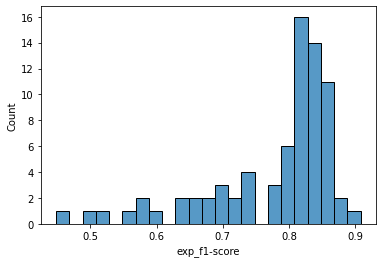

In [9]:
sns.histplot(df[df["transfer_learned"]==False]["exp_f1-score"], binwidth=0.02)

In [10]:
df[df["ID"] == df[df["transfer_learned"]==True].iloc[0]["orig_model_ID"]].columns

Index(['alpha_0', 'backbone', 'batch_size', 'exp_f1-score',
       'exp_f1-score_CdSe', 'exp_f1-score_katherine', 'exp_iou',
       'exp_iou_CdSe', 'exp_iou_katherine', 'exp_loss', 'exp_loss_CdSe',
       'exp_loss_katherine', 'schedule', 'seed', 'substrate_thicknesses',
       'target_dose', 'ID', 'CdSe_f1-score', 'CdSe_iou_score', 'CdSe_loss',
       'Kate_f1-score', 'Kate_iou_score', 'Kate_loss', 'Kath_f1-score',
       'Kath_iou_score', 'Kath_loss', 'f1-score', 'iou_score', 'loss', 'lr',
       'val_f1-score', 'val_iou_score', 'val_loss', 'series',
       'transfer_learned', 'folder', 'expt_generator_seed', 'expt_val_split',
       'orig_model_ID', 'best_val_f1', 'best_CdSe_f1', 'best_Kath_f1',
       'CdSe_f1_at_val_peak', 'Kath_f1_at_val_peak', 'epoch', 'schedule_rate',
       'schedule_timing', 'orig_series', 'substrate_thicknesses_str'],
      dtype='object')

In [11]:
class palette_map:
    def __init__(self, color_dict):
        self.colors = color_dict

    def __getitem__(self, indices):
        if isinstance(indices, tuple):
            return self.colors[indices[0]][indices[1]]
        else:
            tmp_idx = len(self.colors[indices])//2
            return self.colors[indices][tmp_idx]

(0.0, 1.0)

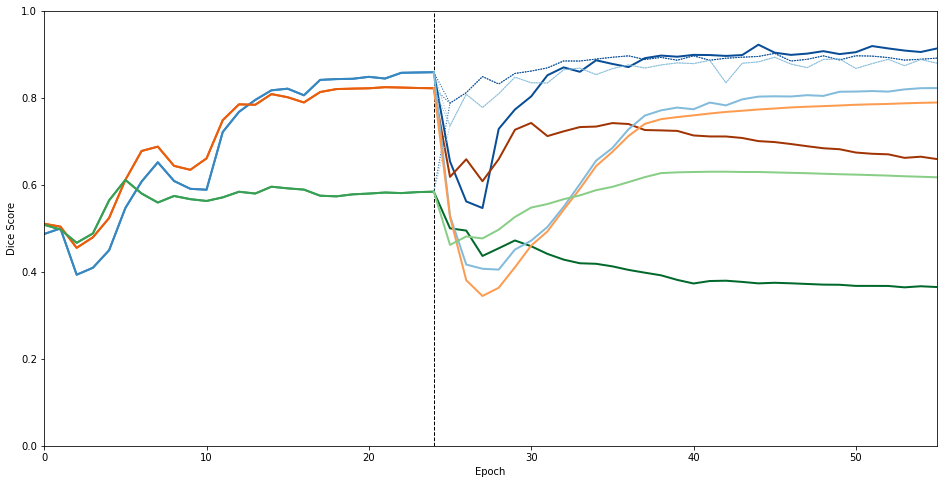

In [12]:
transfer_df = df[df["transfer_learned"]==True]
synth_df = df[df["transfer_learned"]==False]

## choose a model and reduce dataframes appropriately
target_model_N = 0
sim_model_row = synth_df.iloc[target_model_N]
target_orig_ID = sim_model_row["ID"]
tr_model_rows = transfer_df[transfer_df["orig_model_ID"]==target_orig_ID]

## aggregate data into plotting dictionaries
s_hist = {}
t_hist = {}


s_hist["sim_train_loss"] = sim_model_row["loss"]
s_hist["sim_val_loss"] = sim_model_row["val_loss"]

s_hist["sim_train_f1"] = sim_model_row["f1-score"]
s_hist["sim_val_f1"] = sim_model_row["val_f1-score"]

s_hist["large_loss"] = sim_model_row["Kate_loss"]
s_hist["small_loss"] = sim_model_row["Kath_loss"]
s_hist["cdse_loss"] = sim_model_row["CdSe_loss"]

s_hist["large_f1"] = sim_model_row["Kate_f1-score"]
s_hist["small_f1"] = sim_model_row["Kath_f1-score"]
s_hist["cdse_f1"] = sim_model_row["CdSe_f1-score"]


splits = [0.2, 0.4, 0.5, 0.6, 0.8]
for split in splits:
    row = tr_model_rows.loc[tr_model_rows["expt_val_split"]==split].iloc[0]
    t_hist[split] = {"loss":row["loss"],
                    "f1":row["f1-score"],
                    "large_f1":row["val_f1-score"],
                    "small_f1":row["Kath_f1-score"],
                    "cdse_f1":row["CdSe_f1-score"],
                    "large_loss":row["val_loss"],
                    "small_loss":row["Kath_loss"],
                    "cdse_loss":row["CdSe_loss"],
                    }

## grab the epoch where transfer learnign effectively begins
tr_epoch = int(np.argmin(s_hist["sim_val_loss"]))
s_hist["x"] = [int(x) for x in range(tr_epoch+1)]

for split in splits:
    t_hist[split]["x"] = [int(x+tr_epoch+1) for x in range(len(t_hist[split]["loss"]))]

#### Make figure
fig = plt.figure(figsize=(16,8))
ax = fig.gca()

ax.axvline(tr_epoch, linestyle="--", linewidth=1.0, color="k")
data_keys = ["large_f1", "small_f1", "cdse_f1"]

ax.set_ylabel("Dice Score")
ax.set_xlabel("Epoch")

greens = sns.color_palette("Greens", n_colors=8)[3:]
oranges = sns.color_palette("Oranges", n_colors=8)[3:]
blues = sns.color_palette("Blues", n_colors=8)[3:]

p_map = palette_map({key:val for key, val in zip(data_keys, [blues, oranges, greens])})
p_map.colors["f1"] = blues

hues = {x:i for i,x in enumerate(splits[::-1])}


p_splits = [0.2, 0.8]
for split in p_splits:
    t_connect_x = np.concatenate([[s_hist["x"][-1]], t_hist[split]["x"]])

    for key in data_keys:
        ax.plot(s_hist["x"], s_hist[key], linewidth=2, color=p_map[key])
        t_connect_y =  np.concatenate([[s_hist[key][-1]], t_hist[split][key]])

        # ax.plot(t_hist[split]["x"], t_hist[split][key], color=color_dict[key])
        ax.plot(t_connect_x, t_connect_y, linewidth=2, color=p_map[key, hues[split]])

        t_connect_y =  np.concatenate([[s_hist[key][-1]], t_hist[split]["f1"]])
        ax.plot(t_connect_x, t_connect_y, linestyle=":", linewidth=1, color=p_map["f1", hues[split]])

ax.set_xlim([0, t_hist[0.2]["x"][-1]])
ax.set_ylim([0,1])

### Making widget

In [13]:
len(synth_df)-1

74

In [16]:
global save_the_figure
save_the_figure = False

def plot_data(data_frame, **kwargs):
    global save_the_figure
    save_the_figure = kwargs["save"]
    
    transfer_df = data_frame[data_frame["transfer_learned"]==True]
    synth_df =    data_frame[data_frame["transfer_learned"]==False]

    ## choose a model and reduce dataframes appropriately
    target_model_N = kwargs["target_model_N"]
    sim_model_row = synth_df.iloc[target_model_N]
    target_orig_ID = sim_model_row["ID"]
    tr_model_rows = transfer_df[transfer_df["orig_model_ID"]==target_orig_ID]

    print(target_orig_ID)
    ## aggregate data into plotting dictionaries
    s_hist = {}
    t_hist = {}

    s_hist["sim_train_loss"] = sim_model_row["loss"]
    s_hist["sim_val_loss"] = sim_model_row["val_loss"]

    s_hist["sim_train_f1"] = sim_model_row["f1-score"]
    s_hist["sim_val_f1"] = sim_model_row["val_f1-score"]

    s_hist["large_loss"] = sim_model_row["Kate_loss"]
    s_hist["small_loss"] = sim_model_row["Kath_loss"]
    s_hist["cdse_loss"] = sim_model_row["CdSe_loss"]

    s_hist["large_f1"] = sim_model_row["Kate_f1-score"]
    s_hist["small_f1"] = sim_model_row["Kath_f1-score"]
    s_hist["cdse_f1"] = sim_model_row["CdSe_f1-score"]


    splits = kwargs["splits"]
    for split in splits:
        row = tr_model_rows.loc[tr_model_rows["expt_val_split"]==split].iloc[0]
        t_hist[split] = {"loss":row["loss"],
                        "f1":row["f1-score"],
                        "large_f1":row["val_f1-score"],
                        "small_f1":row["Kath_f1-score"],
                        "cdse_f1":row["CdSe_f1-score"],
                        "large_loss":row["val_loss"],
                        "small_loss":row["Kath_loss"],
                        "cdse_loss":row["CdSe_loss"],
                        }

    ## grab the epoch where transfer learnign effectively begins
    tr_epoch = int(np.argmin(s_hist["sim_val_loss"]))
    s_hist["x"] = [int(x) for x in range(tr_epoch+1)]

    for split in splits:
        t_hist[split]["x"] = [int(x+tr_epoch+1) for x in range(len(t_hist[split]["loss"]))]

    #### Make figure
    fig = plt.figure(figsize=(16,8), facecolor="w")
    ax = fig.gca()

    ax.axvline(tr_epoch+0.5, linestyle="--", linewidth=1.5, color="gray")

    if kwargs["metric"] == "Loss":
        metric = "_loss"
        tt_metric = "loss"
    else:
        metric = "_f1"
        tt_metric = "f1"
    
    data_base = ["large", "small", "cdse"]
    data_filters = [x.split()[0].lower() for x in kwargs["exp_datasets"]]
    data_keys = [x+metric for x in data_base if x in data_filters]
    data_labels = [x for x in data_base if x in data_filters]

    ax.set_xlabel("Epoch", fontsize=14)
    if kwargs["metric"] == "Loss":
        ax.set_ylabel("Loss", fontsize=14)
    else:
        ax.set_ylabel("Dice Score", fontsize=14)

    greens = sns.color_palette("Greens", n_colors=8)[3:]
    oranges = sns.color_palette("Oranges", n_colors=8)[3:]
    blues = sns.color_palette("Blues", n_colors=8)[3:]
    purples = sns.color_palette("Purples", n_colors=8)[3:]

    data_color_keys = [x+metric for x in data_base]
    p_map = palette_map({key:val for key, val in zip(data_color_keys, [blues, oranges, greens])})
    p_map.colors[tt_metric] = blues
    p_map.colors["sim"] = purples

    perm_splits = [0.2, 0.4, 0.5, 0.6, 0.8]
    hues = {x:i for i,x in enumerate(perm_splits)}

    if kwargs["plot_sim_metric"]:
        ax.plot(s_hist["x"], s_hist["sim_val"+metric][:tr_epoch+1], linewidth=2, color=p_map["sim"])

        if kwargs["plot_tt_metric"]:
            ax.plot(s_hist["x"], s_hist["sim_train"+metric][:tr_epoch+1],  linestyle=(0, (5,5)), linewidth=2, color=p_map["sim"])


    for split in kwargs["splits"]:
        t_connect_x = np.concatenate([[s_hist["x"][-1]], t_hist[split]["x"]])

        for key in data_keys:
            ax.plot(s_hist["x"], s_hist[key][:tr_epoch+1], linewidth=2, color=p_map[key])
            t_connect_y =  np.concatenate([[s_hist[key][tr_epoch]], t_hist[split][key]])

            # ax.plot(t_hist[split]["x"], t_hist[split][key], color=p_map[key, hues[split]])
            ax.plot(t_connect_x, t_connect_y, linewidth=2, color=p_map[key, hues[split]])

            if kwargs["plot_tt_metric"]:
                t_connect_y =  np.concatenate([[s_hist["large"+metric][tr_epoch]], t_hist[split][tt_metric]])
                # ax.plot(t_hist[split]["x"], t_hist[split][tt_metric], linestyle=(0, (5,5)), linewidth=2, color=p_map[tt_metric, hues[split]])
                ax.plot(t_connect_x, t_connect_y, linestyle=(0, (5,5)), linewidth=2, color=p_map[tt_metric, hues[split]])

    

    x_max = 0
    for split in kwargs["splits"]:
        tx_max = t_hist[split]["x"][-1]
        x_max = tx_max if tx_max > x_max else x_max
    ax.set_xlim([0, x_max])
    ax.set_ylim([0, kwargs["y_range"]])
    ax.grid()
    ax.text(x=tr_epoch+4.5, y=0.1, s="Training on Large Au NP data", fontsize=14, ha="left")
    ax.text(x=(tr_epoch-2.5)/x_max, y=0.1, s="Training on Simulated Au NP Data", fontsize=14, ha="right", transform=ax.transAxes)
    ax.text(x=(tr_epoch+0.5)/x_max, y=0.1, s="Transfer Learning Begins", rotation=90, fontsize=14, va="bottom", ha="right", transform=ax.transAxes)

    # custom_lines = [Line2D([0], [0], color=p_map[key], lw=2) for key in data_keys]

    label_map = {"large":"Large Au NPs", "small":"Small Au NPs", "cdse":"CdSe NPs"}
    custom_labels = [label_map[x] for x in data_labels]

    # if kwargs["plot_tt_metric"]:
    #     custom_lines = [Line2D([0], [0], color=p_map[tt_metric], lw=2, linestyle=(0,(3,3)))] + custom_lines
    #     custom_labels = ["Training Data"] + custom_labels
        
    # if kwargs["plot_sim_metric"]:
    #     custom_lines = [Line2D([0], [0], color=p_map["sim"], lw=2)] + custom_lines
    #     custom_labels = ["Simulated Data"] + custom_labels

    # ax.legend(custom_lines, custom_labels, loc="upper left", bbox_to_anchor=(1.0, 1.0))

    ## making a cursed custom legend
    w = 0.0125*x_max # width and height
    h = 0.02
    
    xs = w*1.5
    ys = h*1.5

    xl = x_max+1 # left and right edges
    yt = 0.95

    ax.add_patch(plt.Rectangle((xl, yt), 2*w, 0.25*h, facecolor="k",
                                clip_on=False, linewidth = 0))

    ax.text(x=xl+1.75*xs, y=yt, s="Validation Data", ha="left", va="center")

    yt -= 1.5*ys

    if kwargs["plot_tt_metric"]:
        ax.add_patch(plt.Rectangle((xl, yt), 0.67*w, 0.25*h, facecolor="k",
                                    clip_on=False, linewidth = 0))

        ax.add_patch(plt.Rectangle((xl+(4/3)*w, yt), 0.67*w, 0.25*h, facecolor="k",
                                    clip_on=False, linewidth = 0))

        ax.text(x=xl+1.75*xs, y=yt, s="Training Data", ha="left", va="center")
        
        yt -= 2*ys
    else:
        yt -= 0.5*ys

    if kwargs["plot_sim_metric"]:
        ax.add_patch(plt.Rectangle((xl+((len(kwargs["splits"])-1)*xs), yt), w, h, facecolor=p_map["sim"],
                                clip_on=False, linewidth = 0))
        ax.text(x=xl+len(kwargs["splits"])*xs, y=yt+ys/4, s="Simulated Data", ha="left", va="center")
        yt -= ys

    for key, label in zip(data_keys, custom_labels):
        for i, split in enumerate(kwargs["splits"][::-1]):
            ax.add_patch(plt.Rectangle((xl+i*xs, yt), w, h, facecolor=p_map[key, hues[split]],
                                    clip_on=False, linewidth = 0))
        ax.text(x=xl+len(kwargs["splits"])*xs, y=yt+ys/4, s=label, ha="left", va="center")
        yt -= ys

    if len(kwargs["splits"]) > 1:
        theta = -50
        yt += ys/2
        ax.text(x=xl, y=yt, s="Less Data", rotation=theta, ha="left", va="top")
        ax.text(x=xl+(len(kwargs["splits"])-1)*xs, y=yt, s="More Data", rotation=theta, ha="left", va="top")
        
    plt.show()

    if save_the_figure:
        fig.savefig(kwargs["fname"], dpi=300, bbox_inches="tight")

def plot_widget(data_frame):
    w_metric =RadioButtons(
                options=['f1 Score', 'Loss'],
                description='Metric',
                disabled=False
            )

    w_split_filter = SelectMultiple(
        options=[0.2, 0.4, 0.5, 0.6, 0.8],
        value=(0.2,),
        description='Val. Data Split',
        disabled=False,
    )

    w_exp_filter = SelectMultiple(
        options=['Large Au', 'Small Au', 'CdSe'],
        value=('Large Au', 'Small Au', 'CdSe'),
        description='Exp. Dataset',
        disabled=False,
    )

    w_line_select = IntSlider(value=0, min=0, max=74, description="Model #")

    w_plot_train = Checkbox(value=False, description="Plot training metrics.")
    w_plot_train_sim = Checkbox(value=False, description="Plot simulated data metrics.")

    w_y_range = widgets.FloatText(
                            value=1.0,
                            description='y-max:',
                            disabled=False
                        )

    w_filename = widgets.Text(
                    value='output.png',
                    description='Filename:',
                    disabled=False
                )

    w_save_fig = Checkbox(value=False, description="Click to save figure!")

    return interact(plot_data, data_frame=fixed(data_frame),
                            target_model_N=w_line_select,
                            splits=w_split_filter,
                            exp_datasets=w_exp_filter,
                            plot_tt_metric=w_plot_train,
                            plot_sim_metric=w_plot_train_sim,
                            metric=w_metric,
                            y_range=w_y_range,
                            fname=w_filename,
                            save=w_save_fig)

In [17]:
W=plot_widget(df)

saver = W.widget.children[-2]

def on_value_change(change):
    saver.value = False

saver.observe(on_value_change, names="value")

interactive(children=(IntSlider(value=0, description='Model #', max=74), SelectMultiple(description='Val. Data…